## Creare un sistema di Spam Detection

Creare un sistema di Spam Detection
L'azienda ProfessionAI vuole realizzare una libreria capace di fare analisi delle email ricevute.

Nello specifico, il CEO ha richiesto di identificare le email di tipo SPAM sulle quali fare analisi contenutistiche.

Il CTO nello specifico ti fornisce un dataset e ti chiede di:
- Addestrare un classificatore per identificare SPAM
- Individuare i Topic principali tra le email SPAM presenti nel dataset
- Calcolare la distanza semantica tra i topics ottenuti, per dedurne l'eterogeneità.
- Estrarre dalle mail NON SPAM le Organizzazioni presenti.

In [1]:
import pandas as pd
import numpy as np
import string
import spacy
import spacy.displacy as displacy
import nltk
from nltk.corpus import stopwords
import re
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Input, LSTM, Dense, Bidirectional, Flatten
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.backend import clear_session
import matplotlib.pyplot as plt
import pickle
import itertools #per generare combinazioni di valori
import gensim.downloader
from gensim.models import Word2Vec, CoherenceModel
import gensim.corpora as corpora
from gensim.models import LdaMulticore as LDA
import pyLDAvis
import pyLDAvis.gensim_models
from pprint import pprint
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import log_loss, classification_report, confusion_matrix, accuracy_score
from scipy import spatial




# !python -m spacy download en_core_web_sm



### <span style="color: #39FF14; font-weight: bold;">IMPORT DATASET</span>

In [2]:
dataset = pd.read_csv("spam_dataset.csv")

dataset.head()



,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0


### <span style="color: #39FF14; font-weight: bold;">CLEAN DATASET</span>

Usually in Natural Language Process the text must be cleaned first, the principal actions regards:

* Bring the text in lower case form, for a machine the words 'house' and 'HOUSE' are differents
* Delete the puntuaction, this is require in most task of natural language process, except for those must product a
 textual output for wich the punctuaction is require
* Delete StopWords, usually they not bring major information at the phrase
* Lemmatization, to bring a word from the inflected form to the base form
* Delete numbers, not always is necessary

As you can see, the previous operations have the main purpose of reducing the dimensionality of a dataset.

In [3]:
#nltk.download('stopwords')

english_stopwords = stopwords.words('english')
english_stopwords.extend(['from', 'subject', 're', 'edu', 'use'])
nlp = spacy.load('en_core_web_sm')
punctuation = set(string.punctuation)

def data_cleaner(sentence):
    sentence = sentence.lower()
    for c in string.punctuation:
        sentence = sentence.replace(c, " ")
    document = nlp(sentence)
    sentence = ' '.join(token.lemma_ for token in document)
    sentence = ' '.join(word for word in sentence.split() if word not in english_stopwords)
    sentence = re.sub('\d', '', sentence)
    sentence = re.sub(' +', " ", sentence)
    
    return sentence

<>:15: DeprecationWarning: invalid escape sequence '\d'
<>:15: DeprecationWarning: invalid escape sequence '\d'
C:\Users\riky_\AppData\Local\Temp\ipykernel_444\2105105266.py:15: DeprecationWarning: invalid escape sequence '\d'
  sentence = re.sub('\d', '', sentence)
C:\Users\riky_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\riky_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


#### Example of usage

In [4]:
print(f"original phrase:\n\n {dataset['text'].loc[0]}")
print("\n\n ********************************************************************* \n\n")
print(f"reduced phrase:\n\n {data_cleaner(dataset['text'].loc[0])}")

original phrase:

 Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .


 ********************************************************************* 


reduced phrase:

 enron methanol meter follow note I give monday preliminary flow datum provide daren please override pop daily volume presently zero reflect daily activity obtain gas control change need asap economic purpose


In [5]:
dataset = pd.DataFrame({ 'TEXT': [data_cleaner(phrase) for phrase in  dataset['text']], 'CLASS' : dataset['label_num'] })
dataset.head()
dataset.shape

(5171, 2)

### <span style="color: #39FF14; font-weight: bold;">TEXT ENCODING</span>

1. ####  <span style="color: #1E90FF; font-weight: bold;">Bag of Words Count Vectorized</span>
    Advantages:

    * Simplicity: Easy to understand and implement. Each document is represented as a vector of word counts.
        Interpretability: The resulting vectors are straightforward to interpret, with each dimension directly corresponding to a word's frequency in the document.

    Disadvantages:

    * High Dimensionality: The vocabulary size can be very large, leading to high-dimensional vectors, which can be computationally expensive to process.
    * Lack of Semantic Meaning: Does not capture the meaning of words or their context. Words like "cat" and "dog" are treated as completely unrelated.
    * Ignoring Word Order: The technique does not consider the order of words, losing syntactic information.

2. ####  <span style="color: #1E90FF; font-weight: bold;">Bag of Words TF-IDF</span>

    Advantages:

    * Relevance Weighting: Words are weighted by their importance. Rare but significant words have higher weights, improving the model's ability to identify key terms in documents.
    * Dimensionality Reduction: Helps mitigate the issue of common words dominating the representation by assigning lower weights to them.

    Disadvantages:

    * High Dimensionality: Like count vectorization, TF-IDF also results in high-dimensional vectors.
    * Limited Semantic Understanding: Though better than plain counts, TF-IDF still doesn't capture the full semantic meaning or context of words.
    * Complexity: Slightly more complex to implement than simple count vectorization, requiring calculation of term frequencies and inverse document frequencies.
    
    Comparison: Bag of Words Count Vectorized vs. Bag of Words TF-IDF
    
    * Improved Accuracy: TF-IDF often provides better results than plain count vectorization by reducing the impact of common words and emphasizing significant terms.
    * Complexity vs. Simplicity: Count vectorization is simpler and faster, making it suitable for quick and basic text analysis, while TF-IDF, being slightly more complex, is more effective for detailed text analysis.

3. <span style="color: #1E90FF; font-weight: bold;">Word Embeddings</span>

    Advantages:

    * Semantic Understanding: Captures semantic relationships between words. Words with similar meanings are located near each other in the vector space.
    * Dimensionality Reduction: Typically results in much lower dimensional vectors compared to Bag of Words models, making computations more efficient.
    * Contextual Information: Some embeddings (like Word2Vec, GloVe) can capture contextual information, enhancing the representation of words in different contexts.

    Disadvantages:

    * Complexity: Requires more computational resources and sophisticated understanding to implement and train.
    * Training Data Dependency: The quality of embeddings heavily depends on the quality and size of the training data. Poor or insufficient data can lead to poor embeddings.
    * Less Interpretability: The vectors are not directly interpretable, as dimensions do not correspond to specific words or frequencies.

    Comparison: Bag of Words Techniques vs. Word Embeddings

    * Dimensionality: Word embeddings result in lower-dimensional vectors compared to Bag of Words techniques, which can have very high dimensionality.
    * Semantic Richness: Word embeddings capture semantic relationships and contextual information, whereas Bag of Words methods generally do not.
    * Interpretability: Bag of Words vectors are easier to interpret since each dimension corresponds to a word or its weight, while word embeddings are more abstract.
    * Computational Efficiency: Word embeddings are computationally more efficient once trained, but their training process can be resource-intensive compared to Bag of Words methods.
    * Application: Word embeddings are generally more powerful for applications requiring semantic understanding, such as language modeling, machine translation, and sentiment analysis, while Bag of Words methods can be sufficient for simpler tasks like text classification or information retrieval.

### <span style="color: #39FF14; font-weight: bold;">SPAM EMAIL DETECTION</span>

In [6]:
def get_LSTM_model(vocabulary_size, output_dim, maxlen, opt, loss_function, list_metrics):
    clear_session()
    model_LSTM = Sequential()
    model_LSTM.add(Embedding(vocabulary_size+1, output_dim, input_length=maxlen))
    model_LSTM.add(Bidirectional(LSTM(16, activation='tanh')))
    model_LSTM.add(Dense(1, activation='sigmoid'))
    model_LSTM.compile(optimizer=opt, loss=loss_function, metrics=list_metrics)
    return model_LSTM

In [7]:
# plot learning curve function

def plot_learning_curves(hist,exp_name):
    plt.figure(figsize=(10,4))
    for subplot,curve in enumerate(['loss','accuracy']):
        plt.subplot(1,2,subplot+1)
        plt.plot(hist.history[curve],label='training')
        plt.plot(hist.history['val_'+curve],label='validation')
        plt.legend()
        plt.title(exp_name+':'+curve)
    plt.tight_layout()

In [8]:
glove_vectors = gensim.downloader.load('fasttext-wiki-news-subwords-300')

In [9]:
def avg_vector(sentence):
    
    to_remove = 0
    vector = np.zeros(glove_vectors.vector_size)
    
    for word in sentence:
        if word in glove_vectors.key_to_index.keys():
            vector += glove_vectors.get_vector(word)
        else:
            to_remove += 1
    
    if len(sentence) == to_remove:
        return np.zeros(glove_vectors.vector_size)
        
    return vector/(len(sentence)-to_remove)



def avg_vector_weighted(sentence, weights):
    vector = np.zeros(glove_vectors.vector_size)
    total_weight = 0.0
    to_remove = 0
    
    for word in sentence:
        if word in glove_vectors.key_to_index.keys():
            vector += glove_vectors.get_vector(word) * float(weights[word])  
            total_weight += float(weights[word])
            
    if total_weight != 0:
        vector /= total_weight
    
    return vector

In [10]:
def email_spam_detection_Ricurrent_Neural_Network(n_split = 2):
    
    RANDOM_SEED = 0

    X = dataset['TEXT'].values
    y = dataset['CLASS'].values

    kf = KFold(n_splits=n_split, shuffle=True, random_state=RANDOM_SEED)

    history = []

    for train_index, test_index in kf.split(X):

        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]


        tokenizer = Tokenizer(num_words= 5000)

        # fit_on_texts: mapping textual word -> index
        tokenizer.fit_on_texts(X_train)
        vocabulary_size = len(tokenizer.word_index)+1

        sequences_train = tokenizer.texts_to_sequences(X_train)
        sequences_test = tokenizer.texts_to_sequences(X_test)

        
        lengths = [len(seq) for seq in sequences_train]
        max_len = int(np.percentile(lengths, 90))

        padded_sequences_train = pad_sequences(sequences_train, maxlen=max_len)
        padded_sequences_test = pad_sequences(sequences_test, maxlen=max_len)

        model = get_LSTM_model(vocabulary_size, 2, max_len, "adam", "binary_crossentropy", ["accuracy"])

        hist = model.fit(padded_sequences_train, y_train, epochs=50, batch_size=32, validation_data=(padded_sequences_test, y_test), verbose=0)
        
        history.append(hist)
        
    return history

In [11]:
def email_spam_detection_MLPClassifier(encoding_method, n_split=2):

    if encoding_method == 'embeddings':

        RANDOM_SEED = 0

        X = dataset['TEXT'].values
        y = dataset['CLASS'].values

        kf = KFold(n_splits=n_split, shuffle=True, random_state=RANDOM_SEED)

        accuracy = []

        for train_index, test_index in kf.split(X):

            X_train = X[train_index]
            y_train = y[train_index]
            X_test = X[test_index]
            y_test = y[test_index]

            
            X_train = np.array( [avg_vector(phrase) for phrase in X_train])
            X_test = np.array( [avg_vector(phrase) for phrase in X_test])

            clf = MLPClassifier(activation='logistic',
                    hidden_layer_sizes=(100,100),
                    max_iter=100000,
                    solver='adam',
                    tol=0.0005,
                    verbose=False)

            clf.fit(X_train, y_train)

            accuracy.append(clf.score(X_test, y_test))

        
        return accuracy

    if encoding_method == 'count vectorized':

        RANDOM_SEED = 0

        X = dataset['TEXT'].values
        y = dataset['CLASS'].values

        kf = KFold(n_splits=n_split, shuffle=True, random_state=RANDOM_SEED)

        accuracy = []

        for train_index, test_index in kf.split(X):

            X_train = X[train_index]
            y_train = y[train_index]
            X_test = X[test_index]
            y_test = y[test_index]


            count_vectorized = CountVectorizer()
            X_train = count_vectorized.fit_transform(X_train)
            X_test = count_vectorized.transform(X_test)
            

            clf = MLPClassifier(activation='logistic',
                    hidden_layer_sizes=(100),
                    max_iter=100000,
                    solver='adam',
                    tol=0.0005,
                    verbose=False)

            clf.fit(X_train, y_train)

            accuracy.append(clf.score(X_test, y_test))

        
        return accuracy


    if encoding_method == 'tfidf vectorized':

        RANDOM_SEED = 0

        X = dataset['TEXT'].values
        y = dataset['CLASS'].values

        kf = KFold(n_splits=n_split, shuffle=True, random_state=RANDOM_SEED)

        accuracy = []

        for train_index, test_index in kf.split(X):

            X_train = X[train_index]
            y_train = y[train_index]
            X_test = X[test_index]
            y_test = y[test_index]


            tfidf_vectorized = TfidfVectorizer()
            X_train = tfidf_vectorized.fit_transform(X_train)
            X_test = tfidf_vectorized.transform(X_test)
            

            clf = MLPClassifier(activation='logistic',
                    hidden_layer_sizes=(100),
                    max_iter=100000,
                    solver='adam',
                    tol=0.0005,
                    verbose=False)

            clf.fit(X_train, y_train)

            accuracy.append(clf.score(X_test, y_test))

        
        return accuracy




In [12]:
def email_spam_detection_NaiveBayes(encoding_method, n_split=2):

    if encoding_method == 'embeddings':

        RANDOM_SEED = 0

        X = dataset['TEXT'].values
        y = dataset['CLASS'].values

        kf = KFold(n_splits=n_split, shuffle=True, random_state=RANDOM_SEED)

        accuracy = []

        for train_index, test_index in kf.split(X):

            X_train = X[train_index]
            y_train = y[train_index]
            X_test = X[test_index]
            y_test = y[test_index]

            
            X_train = np.array( [avg_vector(phrase) for phrase in X_train])
            X_test = np.array( [avg_vector(phrase) for phrase in X_test])

            NB = GaussianNB()
            NB.fit(X_train, y_train)

            accuracy.append(accuracy_score(y_test, NB.predict(X_test)))

        
        return accuracy

    if encoding_method == 'count vectorized':

        RANDOM_SEED = 0

        X = dataset['TEXT'].values
        y = dataset['CLASS'].values

        kf = KFold(n_splits=n_split, shuffle=True, random_state=RANDOM_SEED)

        accuracy = []

        for train_index, test_index in kf.split(X):

            X_train = X[train_index]
            y_train = y[train_index]
            X_test = X[test_index]
            y_test = y[test_index]


            count_vectorized = CountVectorizer()
            X_train = count_vectorized.fit_transform(X_train)
            X_test = count_vectorized.transform(X_test)
            
            NB = MultinomialNB()
            NB.fit(X_train, y_train)

            accuracy.append(accuracy_score(y_test, NB.predict(X_test)))

        
        return accuracy


    if encoding_method == 'tfidf vectorized':

        RANDOM_SEED = 0

        X = dataset['TEXT'].values
        y = dataset['CLASS'].values

        kf = KFold(n_splits=n_split, shuffle=True, random_state=RANDOM_SEED)

        accuracy = []

        for train_index, test_index in kf.split(X):

            X_train = X[train_index]
            y_train = y[train_index]
            X_test = X[test_index]
            y_test = y[test_index]


            tfidf_vectorized = TfidfVectorizer()
            X_train = tfidf_vectorized.fit_transform(X_train)
            X_test = tfidf_vectorized.transform(X_test)
            

            NB = MultinomialNB()
            NB.fit(X_train, y_train)

            accuracy.append(accuracy_score(y_test, NB.predict(X_test)))

        
        return accuracy




In [13]:
email_spam_detection_NaiveBayes("embeddings", n_split=5)

[0.7314009661835749,
 0.7350096711798839,
 0.7040618955512572,
 0.7166344294003868,
 0.6818181818181818]

In [14]:
email_spam_detection_NaiveBayes("tfidf vectorized", n_split=5)

[0.9169082125603865,
 0.9168278529980658,
 0.9274661508704062,
 0.9119922630560928,
 0.9061895551257253]

In [15]:
email_spam_detection_NaiveBayes("count vectorized", n_split=5)

[0.9710144927536232,
 0.9777562862669246,
 0.9893617021276596,
 0.971953578336557,
 0.9758220502901354]

In [16]:
email_spam_detection_MLPClassifier('embeddings')

[0.7911832946635731, 0.7822050290135396]

In [17]:
email_spam_detection_MLPClassifier('count vectorized')

[0.9752513534416086, 0.9794970986460348]

In [18]:
email_spam_detection_MLPClassifier('tfidf vectorized')

[0.9822119102861562, 0.988394584139265]

In [19]:
history = email_spam_detection_Ricurrent_Neural_Network()

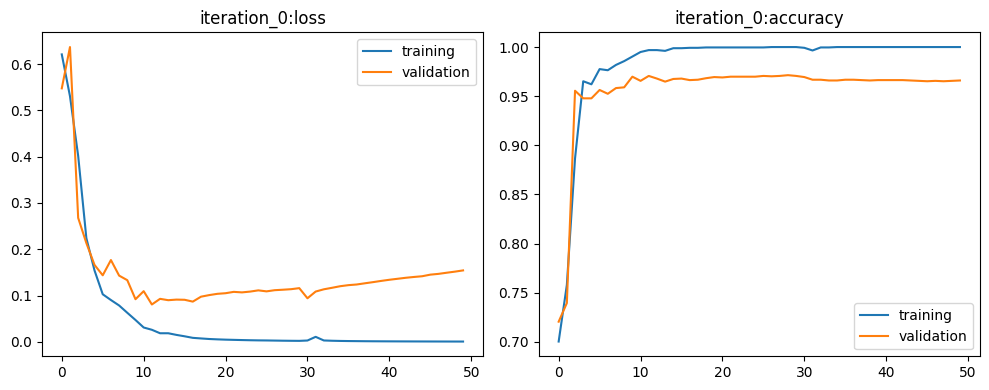

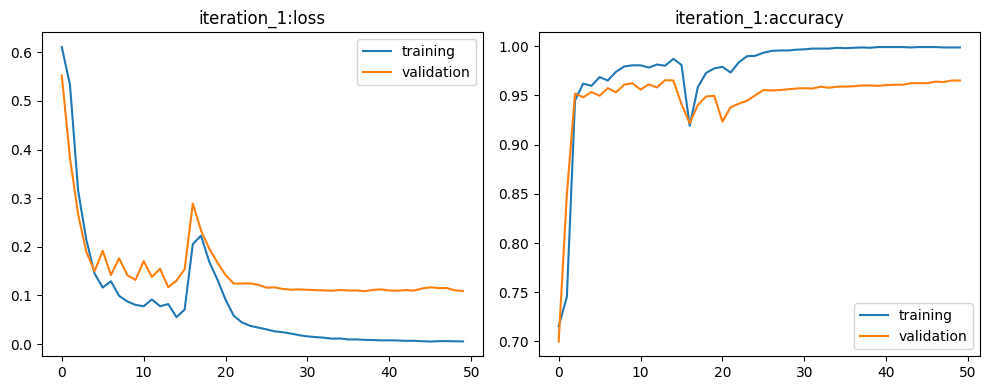

In [20]:
for i, hist in enumerate(history):
    
    plot_learning_curves(hist, "iteration_" + str(i))

both the models with neural networks and naive Bayes have given excellent results regarding the detection of spam emails, obtaining an accuracy of approximately 98% for both, consequently we opt for the computationally faster model which is the naive Bayes.

furthermore, it was found that both for neural networks and for naive Bayes, the most performing text coding methods are bag of words.

this may be due to how the embeddings were calculated, i.e. for each sentence the average embedding was calculated (i.e. the average of the embedding vectors of each word contained in the sentence) which leads to a loss of information compared to the bag of words.

### <span style="color: #39FF14; font-weight: bold;">TOPIC CLASSIFICATION</span>

In [21]:
# Create Dictionary
tokenized_dataset = [ [word for word in phrase.split() ] for phrase in dataset['TEXT'][[bool(x) for x in dataset['CLASS']]] ]
id2word = corpora.Dictionary(tokenized_dataset)

# Filter  the extremes and rares words

total_documents = len(tokenized_dataset)
min_doc_frequency = int(0.02 * total_documents)
id2word.filter_extremes(no_below=min_doc_frequency, no_above=0.5)


#id2word.filter_extremes(no_below=int(no_below=0.02*len(tokenized_dataset)), no_above=0.9)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in tokenized_dataset]

In [22]:

# function that calculate the coherence score for a give number of topic 
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics, 
                                       passes=5)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Suppose to want to test from 2 to 10 topic
start = 2
limit = 10
step = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=tokenized_dataset, start=start, limit=limit, step=step)

# print the score
for num_topics, coherence_value in zip(range(start, limit, step), coherence_values):
    print(f"Num Topics = {num_topics}, Coherence Value = {coherence_value}")

# determines the numbero of topics with the highest score
optimal_num_topics = range(start, limit, step)[coherence_values.index(max(coherence_values))]
print(f"Optimal number of topics: {optimal_num_topics}")

# retrain model with the optimal numbers of topics
optimal_lda_model = gensim.models.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=optimal_num_topics,
                                           passes=5)


Num Topics = 2, Coherence Value = 0.48583325323761173
Num Topics = 3, Coherence Value = 0.6361751926438189
Num Topics = 4, Coherence Value = 0.4788291685741085
Num Topics = 5, Coherence Value = 0.6409373938873612
Num Topics = 6, Coherence Value = 0.5526267690611113
Num Topics = 7, Coherence Value = 0.5211163658579215
Num Topics = 8, Coherence Value = 0.607756170799944
Num Topics = 9, Coherence Value = 0.5539432121240613
Optimal number of topics: 5


In [23]:
# Visualizzazione dei topic
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_lda_model, corpus, id2word)
pyLDAvis.display(vis)


In [24]:
pprint(optimal_lda_model.print_topics())
doc_lda = optimal_lda_model[corpus]

[(0,
  '0.024*"company" + 0.019*"price" + 0.013*"pill" + 0.010*"stock" + '
  '0.009*"information" + 0.009*"security" + 0.009*"adobe" + 0.008*"statement" '
  '+ 0.008*"international" + 0.008*"window"'),
 (1,
  '0.049*"I" + 0.011*"get" + 0.009*"one" + 0.008*"time" + 0.008*"company" + '
  '0.008*"new" + 0.008*"say" + 0.008*"account" + 0.008*"money" + 0.007*"make"'),
 (2,
  '0.029*"e" + 0.028*"I" + 0.019*"com" + 0.019*"r" + 0.015*"c" + '
  '0.014*"please" + 0.013*"message" + 0.013*"free" + 0.012*"p" + 0.012*"x"'),
 (3,
  '0.017*"statement" + 0.017*"company" + 0.012*"computron" + 0.012*"stock" + '
  '0.011*"may" + 0.011*"com" + 0.011*"information" + 0.010*"email" + '
  '0.010*"within" + 0.009*"price"'),
 (4,
  '0.044*"http" + 0.028*"td" + 0.027*"font" + 0.023*"com" + 0.018*"www" + '
  '0.015*"size" + 0.014*"get" + 0.011*"href" + 0.010*"color" + 0.009*"face"')]


### <span style="color: #39FF14; font-weight: bold;">SEMANTIC DISTANCE BETWEEN TOPIC</span>

In [25]:
def get_topic_words(lda_model, num_words=10):
    topics = lda_model.print_topics(num_words=num_words)
    topic_words = []
    for topic in topics:
        words = [word for word, prob in lda_model.show_topic(topic[0], topn=num_words)]
        topic_words.append(words)
    return topic_words



def get_topic_probabilities(lda_model, num_words=10):
    topic_probabilities = []
    for i in range(lda_model.num_topics):
        topic = lda_model.show_topic(i, topn=num_words)
        probabilities = {word: prob for word, prob in topic}
        topic_probabilities.append(probabilities)
    return topic_probabilities


topic_words = get_topic_words(optimal_lda_model, num_words=10)
topic_probabilities = get_topic_probabilities(optimal_lda_model, num_words=10)

topic_embeddings = []

for i in range(len(topic_words)):

    topic_embeddings.append(avg_vector_weighted(topic_words[i], topic_probabilities[i]))



In [26]:
#distance from topic 0 to topic 1
print(1 - spatial.distance.cosine(topic_embeddings[0], topic_embeddings[1]))

#distance from topic 0 to topic 2
print(1 - spatial.distance.cosine(topic_embeddings[0], topic_embeddings[2]))

#distance from topic 1 to topic 2
print(1 - spatial.distance.cosine(topic_embeddings[1], topic_embeddings[2]))



0.21566097774334514
0.004154127489495618
0.7172118370764317


### <span style="color: #39FF14; font-weight: bold;">EXTRACT THE ORGANIZATION PRESENT FROM NON-SPAM EMALIS</span>

In [27]:
nlp = nlp = spacy.load("en_core_web_trf")

list_spam = [phrase for phrase in dataset['TEXT'][[bool(x) for x in (1 - dataset['CLASS']) ]]]

def filter_organizations(org_set):
    valid_organizations = set()
    for org in org_set:
        if any(char.isalpha() for char in org):
            valid_organizations.add(org)
    return valid_organizations


organizations = set()

for i in range(len(list_spam)):
    doc = nlp(list_spam[i])
    organizations.update([ent.text for ent in doc.ents if ent.label_ == "ORG"])

filtered_organizations = filter_organizations(organizations)

print("Organizzazioni trovate:", filtered_organizations)


Organizzazioni trovate: {'volume attach', 'vonda', 'origination management team', 'newco', 'enron exist capital', 'davidfinley', 'sitara cpr', 'global place', 'ena enron freight', 'enron enronxgate', 'kerr mcgee', 'original entertainment sideline', 'new political administration', 'oil gas hesco', 'white petr bob', 'forward way state', 'unify offsystem', 'groupwise', 'crosstex energy', 'newsstand', 'coral energy resource', 'enron building ac', 'payroll hr', 'neon lesson', 'olson espllp com', 'tgc agency', 'vastar resources inc', 'strong supportive congregation', 'swift energy', 'gi joe toy corp', 'mdwerner cp', 'powder river gathering bridgeline', 'oasis', 'resource co', 'ghank ect', 'enerfin tetco', 'seasonal differential', 'kofax com', 'nicole dalmac com', 'high island hpl meter', 'danken', 'brokercity', 'epgt', 'kindermorgan', 'telstreet com', 'portland general electric eott enron', 'mtg gas asset group', 'swroy startech', 'williams', 'conoco inc', 'natural gas supply association', '

: 